### This is part 4 in topic modelling series
- Here, I prepare an NMF model on the Amazon Fine Food Reviews.

In [101]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils,models
from nltk import word_tokenize
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
from sklearn.decomposition import NMF
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore")

In [3]:
clean_data = pd.read_pickle("clean_data_lemmatized.pkl")

In [4]:
#data check
clean_data.info()
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395172 entries, 0 to 395171
Data columns (total 3 columns):
id        395172 non-null int64
title     395172 non-null object
review    395172 non-null object
dtypes: int64(1), object(2)
memory usage: 9.0+ MB


,id,title,review
0,0,Good Quality Dog Food,buy vitality can dog food product good quality...
1,1,Not as Advertised,product arrive label jumbo salt peanut peanut...
2,2,"""Delight"" says it all",confection century light pillowy citrus gela...
3,3,Cough Medicine,secret ingredient robitussin addition root be...
4,4,Great taffy,great taffy great price wide assortment yummy...


In [5]:
training,testing = np.split(clean_data,[int(0.7*len(clean_data))])
testing.reset_index(drop = True,inplace = True)

### Stopwords

In [6]:
#updated stop-words
stop_words = ["a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","different","do","does","doing","done","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","have","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","it","itd","its","itself","j","just","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","shes","should","show","showed","shown","showns","shows","significant","significantly",
               "similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure","t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","thats","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","thereof","therere","theres","thereto","thereupon","these","they","theyd","theyre","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","went","were","werent","what","whatever","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","your","youre","yours","yourself","yourselves","z","zero"]

#adding term "perfect" noticed previously
domain1 = ["taste","excellent","love","nice","better","wonderful","stuff","delicious","yummy","tasty","favorite","product",
          "flavor","better","best","great","good","pretty","pleasant","surprise","decent","tasting","quality","buy","will",
          "yum","omg","tastes","market","special","service","shipping","easy","perfect","shipment","shipped"]

stop_words.extend(domain1)
domain2 = ["store","find","amazon","order","item","arrive","receive","package","open","pack","packet","box","food","review",
           "eat","well","recommend","highly","help","purchase","money","price","cost","free","pay","payment","list","feel",
          "subscribe","thing","sell","top","recommendation"]
stop_words.extend(domain2)

# Non-Negative Matrix Factorization (NMF)

- NMF basically works very similar to SVD, which is it breaks up a matrix or decomposes a matrix into 2. SO, when our original matrix is a document-term matrix, through NMF we can decompose it to 2 matrices, document-topic matrix and topic-term matrix. One additional property that differentiats NMF from SVD is, it only allows for non-negative elements in the matrix - This property works really well in applications like Topic Modelling since negative elements/ negative weightage don't make much sense for different terms.

### NMF Advantages and differentiators
- While LDA is a probabilistic approach, NMF is done through matrix factorization 
- Faster and more Scalable than LDA

#### NMF Attempt #1 (using all text)

In [98]:
#preparing document-term matrix
docs = list(training.review)
vec = CountVectorizer(lowercase = True, stop_words = stop_words,ngram_range = (1,3),max_features = 5000)
X = vec.fit_transform(docs)

In [99]:
#we can directly convert our scipy_sparse_matrix 'X' into genism corpus using matutils
corpus = matutils.Sparse2Corpus(X.T)

In [100]:
#id2word is a dictionary containing all terms(mapped to a code) and their locations(indexes) in term-document matrix
id2word = dict([(k,v) for k,v in enumerate(vec.get_feature_names())])

In [102]:
#Lets save our corpus in "mm" format as it can be processed faster
#corpora.MmCorpus.serialize('all_text_corpus.mm',corpus)
corpusmm = corpora.MmCorpus('all_text_corpus.mm')

#### * Although we have an idea on the number of topics, lets use coherence scores to understand number of topics we need to extract

In [103]:
c_score = []
for topic in range(10,40,4):
    nmf_model = Nmf(corpus = corpusmm,id2word = id2word, num_topics = topic,eval_every = None,passes=3)
    umass_metric = CoherenceModel(model = nmf_model,corpus = corpusmm,coherence = "u_mass")
    c_score.append(umass_metric.get_coherence())

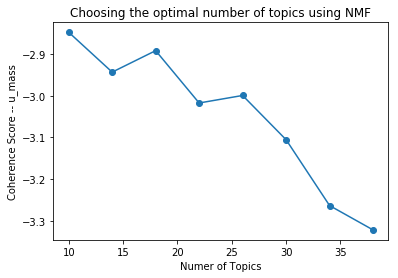

In [104]:
topics = range(10,40,4)
#umass-graph
plt.figure()
plt.plot(topics,c_score,marker = "o")
plt.xlabel("Numer of Topics")
plt.ylabel("Coherence Score -- u_mass")
plt.title("Choosing the optimal number of topics using NMF") 
plt.show()

We again get the similar range (between 10-25). That gives us an additional confirmation! Lets start with 10,15 and 20 topics and understand the distinct themes and then build our final model.

In [105]:
#nmf model for 10 topics
nmf10 = Nmf(corpus = corpusmm,id2word = id2word, num_topics = 10,eval_every = None,passes=3)
nmf10.print_topics()

[(0,
  '0.110*"dog" + 0.039*"treat" + 0.010*"chew" + 0.009*"feed" + 0.009*"ingredient" + 0.008*"small" + 0.007*"pet" + 0.006*"year" + 0.006*"day" + 0.006*"vet"'),
 (1,
  '0.068*"oil" + 0.067*"brand" + 0.050*"coconut" + 0.028*"chip" + 0.021*"olive" + 0.020*"coconut oil" + 0.015*"olive oil" + 0.014*"hair" + 0.009*"year" + 0.009*"coconut water"'),
 (2,
  '0.143*"coffee" + 0.038*"cup" + 0.012*"roast" + 0.011*"brew" + 0.010*"strong" + 0.010*"bean" + 0.009*"cup coffee" + 0.009*"blend" + 0.008*"starbuck" + 0.007*"pod"'),
 (3,
  '0.126*"bag" + 0.035*"salt" + 0.028*"chip" + 0.009*"potato" + 0.007*"small" + 0.007*"tea bag" + 0.006*"popcorn" + 0.006*"pound" + 0.006*"oz" + 0.006*"pepper"'),
 (4,
  '0.021*"time" + 0.019*"cookie" + 0.011*"bar" + 0.010*"snack" + 0.009*"day" + 0.008*"calorie" + 0.007*"peanut" + 0.006*"butter" + 0.006*"work" + 0.006*"year"'),
 (5,
  '0.136*"chocolate" + 0.039*"bar" + 0.029*"dark" + 0.022*"dark chocolate" + 0.019*"milk" + 0.013*"cocoa" + 0.013*"hot" + 0.012*"sweet" + 0.

In [106]:
#nmf model for 15 topics
nmf15 = Nmf(corpus = corpusmm,id2word = id2word, num_topics = 15,eval_every = None,passes=3)
nmf15.print_topics()

[(0,
  '0.099*"sugar" + 0.019*"sweet" + 0.015*"syrup" + 0.012*"ingredient" + 0.011*"sweetener" + 0.011*"natural" + 0.009*"calorie" + 0.009*"juice" + 0.008*"fruit" + 0.008*"low"'),
 (1,
  '0.109*"dog" + 0.039*"treat" + 0.010*"chew" + 0.009*"ingredient" + 0.009*"small" + 0.008*"feed" + 0.007*"time" + 0.007*"day" + 0.007*"pet" + 0.006*"dog treat"'),
 (2,
  '0.190*"tea" + 0.033*"green" + 0.027*"green tea" + 0.010*"tea bag" + 0.009*"black" + 0.008*"black tea" + 0.007*"leave" + 0.007*"brew" + 0.006*"tea tea" + 0.006*"strong"'),
 (3,
  '0.072*"brand" + 0.013*"sweet" + 0.012*"year" + 0.010*"time" + 0.009*"rice" + 0.008*"organic" + 0.008*"potato" + 0.008*"chip" + 0.005*"baby" + 0.005*"local"'),
 (4,
  '0.156*"cookie" + 0.017*"chip" + 0.012*"ginger" + 0.011*"soft" + 0.010*"gluten" + 0.009*"chocolate chip" + 0.008*"bit" + 0.008*"chewy" + 0.008*"chocolate" + 0.008*"texture"'),
 (5,
  '0.153*"cup" + 0.017*"keurig" + 0.014*"time" + 0.014*"cup coffee" + 0.011*"brew" + 0.010*"day" + 0.009*"work" + 0.0

In [107]:
#nmf model for 20 topics
nmf20 = Nmf(corpus = corpusmm,id2word = id2word, num_topics = 20,eval_every = None,passes=3)
nmf20.print_topics()

[(0,
  '0.096*"peanut" + 0.093*"butter" + 0.069*"peanut butter" + 0.033*"treat" + 0.013*"cookie" + 0.012*"calorie" + 0.011*"jar" + 0.011*"fat" + 0.010*"pb" + 0.007*"cracker"'),
 (1,
  '0.092*"mix" + 0.034*"time" + 0.024*"green" + 0.024*"day" + 0.020*"bread" + 0.016*"green tea" + 0.014*"add" + 0.013*"cake" + 0.011*"year" + 0.010*"gluten"'),
 (2,
  '0.156*"bag" + 0.010*"tea bag" + 0.010*"small" + 0.008*"pound" + 0.008*"size" + 0.007*"large" + 0.007*"lb" + 0.007*"candy" + 0.007*"plastic" + 0.007*"fresh"'),
 (3,
  '0.109*"sweet" + 0.042*"potato" + 0.041*"chip" + 0.019*"rice" + 0.016*"potato chip" + 0.014*"sweet potato" + 0.013*"honey" + 0.011*"bit" + 0.008*"snack" + 0.007*"cereal"'),
 (4,
  '0.202*"cup" + 0.025*"coffee" + 0.022*"keurig" + 0.021*"cup coffee" + 0.017*"brew" + 0.009*"machine" + 0.008*"brewer" + 0.008*"add" + 0.008*"hot" + 0.007*"strong"'),
 (5,
  '0.220*"tea" + 0.031*"green" + 0.028*"green tea" + 0.011*"tea bag" + 0.010*"black" + 0.009*"black tea" + 0.008*"leave" + 0.007*"bre

In [108]:
#nmf model for 25 topics
nmf25 = Nmf(corpus = corpusmm,id2word = id2word, num_topics = 25,eval_every = None,passes=3)
nmf25.print_topics()

[(11,
  '0.034*"syrup" + 0.014*"bad" + 0.014*"sweet" + 0.014*"year" + 0.012*"corn" + 0.012*"honey" + 0.011*"high" + 0.009*"maple" + 0.009*"fructose" + 0.008*"corn syrup"'),
 (14,
  '0.031*"rice" + 0.021*"add" + 0.021*"time" + 0.020*"noodle" + 0.020*"soup" + 0.019*"chicken" + 0.017*"cook" + 0.014*"pasta" + 0.010*"meal" + 0.009*"minute"'),
 (20,
  '0.042*"time" + 0.042*"milk" + 0.024*"baby" + 0.024*"cereal" + 0.023*"day" + 0.014*"month" + 0.012*"year" + 0.011*"formula" + 0.011*"work" + 0.010*"start"'),
 (3,
  '0.018*"day" + 0.015*"healthy" + 0.014*"almond" + 0.013*"diet" + 0.013*"natural" + 0.012*"blue" + 0.011*"energy" + 0.010*"body" + 0.010*"seed" + 0.009*"work"'),
 (0,
  '0.103*"water" + 0.035*"bottle" + 0.012*"time" + 0.011*"coconut" + 0.010*"hair" + 0.008*"coconut water" + 0.008*"ph" + 0.007*"essentia" + 0.007*"oil" + 0.006*"work"'),
 (4,
  '0.162*"bag" + 0.011*"tea bag" + 0.010*"small" + 0.008*"pound" + 0.008*"size" + 0.008*"large" + 0.007*"lb" + 0.007*"plastic" + 0.007*"time" + 0.

In [109]:
c_score2 = []
for topic in range(10,16,1):
    nmf_model = Nmf(corpus = corpusmm,id2word = id2word, num_topics = topic,eval_every = None,passes=3)
    umass_metric = CoherenceModel(model = nmf_model,corpus = corpusmm,coherence = "u_mass")
    c_score2.append(umass_metric.get_coherence())

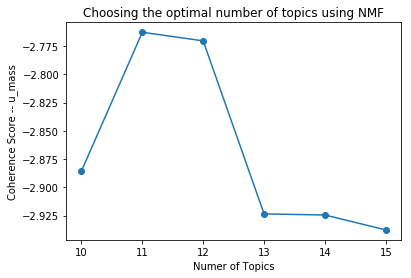

In [110]:
topics = range(10,16,1)
#umass-graph
plt.figure()
plt.plot(topics,c_score2,marker = "o")
plt.xlabel("Numer of Topics")
plt.ylabel("Coherence Score -- u_mass")
plt.title("Choosing the optimal number of topics using NMF") 
plt.show()

## Final NMF model

In [111]:
#nmf model for 25 topics
nmf11 = Nmf(corpus = corpusmm,id2word = id2word, num_topics = 11,eval_every = None,passes=100)
nmf11.print_topics()

[(0,
  '0.141*"bag" + 0.011*"chip" + 0.010*"small" + 0.009*"tea bag" + 0.008*"size" + 0.007*"candy" + 0.007*"pound" + 0.007*"snack" + 0.007*"large" + 0.006*"lb"'),
 (1,
  '0.105*"cat" + 0.014*"dry" + 0.014*"chicken" + 0.011*"feed" + 0.010*"treat" + 0.009*"ingredient" + 0.009*"brand" + 0.008*"pet" + 0.008*"year" + 0.008*"diet"'),
 (2,
  '0.187*"tea" + 0.033*"green" + 0.027*"green tea" + 0.010*"drink" + 0.010*"black" + 0.009*"tea bag" + 0.007*"black tea" + 0.007*"leave" + 0.006*"brew" + 0.006*"tea tea"'),
 (3,
  '0.059*"cookie" + 0.021*"chip" + 0.015*"snack" + 0.014*"fat" + 0.013*"calorie" + 0.011*"salt" + 0.010*"peanut" + 0.010*"butter" + 0.009*"sweet" + 0.008*"sugar"'),
 (4,
  '0.165*"coffee" + 0.013*"roast" + 0.011*"bean" + 0.010*"strong" + 0.010*"drink" + 0.010*"starbuck" + 0.009*"brew" + 0.009*"blend" + 0.008*"vanilla" + 0.007*"dark"'),
 (5,
  '0.117*"chocolate" + 0.047*"bar" + 0.025*"dark" + 0.020*"dark chocolate" + 0.019*"milk" + 0.011*"cocoa" + 0.009*"sweet" + 0.009*"candy" + 0.0

So now, we have our final topics from the NMF model, lets summarize them into the themes they represent:

    1. Salty Snacks
    2. Cat Food
    3. Tea(s)
    4. Sweet Snacks
    5. Coffee Flavors
    6. Chocolates
    7. Hair products
    8. Recipe
    9. Coffee equipments
    10. Beverages
    11. Dog Treats/ Food

#### Model Insights

## Finding the most dominant topic in each review

In [163]:
docs_with_topics = pd.DataFrame(columns = ["document_ID","dominant_topic","perc_topic","keywords","review"])
docs_with_topics["document_ID"] = training.id
docs_with_topics["review"] = training.review

In [164]:
for i in range(len(corpusmm)):
    if corpus[i]:
        topic,topic_perc = sorted(nmf11[corpusmm[i]],key = lambda x:x[1],reverse = True)[0]
        topic_keywords = ', '.join([word for word,word_perc in nmf11.show_topic(topic)])
        doc_topic_dist = pd.Series([topic,topic_perc,topic_keywords])
        docs_with_topics.at[i,"dominant_topic"],docs_with_topics.at[i,"perc_topic"],docs_with_topics.at[i,"keywords"] = doc_topic_dist
    else:
        doc_topic_dist = pd.Series([-1,0.0,"NA"])
        docs_with_topics.at[i,"dominant_topic"],docs_with_topics.at[i,"perc_topic"],docs_with_topics.at[i,"keywords"] = doc_topic_dist

In [165]:
docs_with_topics.head(10)

,document_ID,dominant_topic,perc_topic,keywords,review
0,0,10,0.965202,"dog, treat, ingredient, chew, feed, small, pet...",buy vitality can dog food product good quality...
1,1,3,0.625889,"cookie, chip, snack, fat, calorie, salt, peanu...",product arrive label jumbo salt peanut peanut...
2,2,10,0.359542,"dog, treat, ingredient, chew, feed, small, pet...",confection century light pillowy citrus gela...
3,3,9,0.576217,"drink, water, sugar, juice, sweet, calorie, bo...",secret ingredient robitussin addition root be...
4,4,7,0.784518,"time, sauce, mix, add, water, day, hot, work, ...",great taffy great price wide assortment yummy...
5,5,0,0.383155,"bag, chip, small, tea bag, size, candy, pound,...",wild hair taffy order pound bag taffy enjoyab...
6,6,7,0.394707,"time, sauce, mix, add, water, day, hot, work, ...",saltwater taffy great flavor soft chewy candy...
7,7,3,0.546424,"cookie, chip, snack, fat, calorie, salt, peanu...",taffy good soft chewy flavor amazing defini...
8,8,1,1,"cat, dry, chicken, feed, treat, ingredient, br...",sprout cat eat grass love rotate wheatgrass rye
9,9,10,0.966479,"dog, treat, ingredient, chew, feed, small, pet...",healthy dog food good digestion good small p...


## Document Distribution for each topic

In [252]:
topic_distribution = pd.DataFrame(columns = ["topic_no","topic_keywords","total_documents","perc_docs"])
topic_distribution.topic_no = range(11)
for i in range(11):
    topic_distribution.at[i,"topic_keywords"] = ', '.join([word for word,perc in nmf11.show_topic(i)])
new_row = pd.DataFrame([pd.Series([-1,"Random review - keywords not available",0,0])])
new_row.columns = ["topic_no","topic_keywords","total_documents","perc_docs"]
topic_distribution = pd.concat([new_row,topic_distribution])
topic_distribution.total_documents = docs_with_topics.dominant_topic.value_counts().sort_index()
topic_distribution.reset_index(drop = True,inplace = True)
topic_distribution.total_documents[0] = docs_with_topics.dominant_topic.value_counts().sort_index()[-1]
topic_distribution.perc_docs = (topic_distribution.total_documents/topic_distribution.total_documents.sum())*100
topic_distribution

,topic_no,topic_keywords,total_documents,perc_docs
0,-1,Random review - keywords not available,146,0.052780
1,0,"bag, chip, small, tea bag, size, candy, pound,...",9015,3.258983
2,1,"cat, dry, chicken, feed, treat, ingredient, br...",7336,2.652014
3,2,"tea, green, green tea, drink, black, tea bag, ...",15187,5.490203
4,3,"cookie, chip, snack, fat, calorie, salt, peanu...",21880,7.909768
5,4,"coffee, roast, bean, strong, drink, starbuck, ...",21157,7.648399
6,5,"chocolate, bar, dark, dark chocolate, milk, co...",12326,4.455932
7,6,"oil, coconut, olive, coconut oil, olive oil, o...",7226,2.612248
8,7,"time, sauce, mix, add, water, day, hot, work, ...",135611,49.024293
9,8,"cup, keurig, cup coffee, water, brew, add, hot...",4451,1.609067


Our reviews are quite distributed with respect to our topics - Most dominant topic is topic 7 which is about "Recipe(s)", and then second comes topic 9 which is about "Beverages". The lowest discussed topic is topic 8 - which is about "Coffee Machine Equipments".

### Key observations
- This result is very different from what we got through LDA.
- We also got 146 such documents, which NMF was not able to assign to any topic (due to lack of key-words). LDA however assigns all the topics to such documents (by default) and therefore, we picked topic 0 as the most dominant topic for these documents.

## Top documents for each topic

In [253]:
#lets get the original data loaded so that we can what the actual review was
clean_data_og = pd.read_pickle("clean_data_original.pkl")

In [254]:
#Lets look at the top documents for each topic
topic_groups = docs_with_topics.groupby("dominant_topic")
ind = []
for topic,grp in topic_groups:
    temp = grp.sort_values(["perc_topic"],ascending = False).head(3)
    ind.append([topic,temp.index])

In [290]:
topic_dic = {-1:'Random',0:'Salty Snacks',1:'Cat Food',2:'Tea(s)',3:'Sweet Snacks',4:'Coffee Flavors',
             5:'Chocolates',6:'Oils',7:'Recipe', 8:'Coffee equipments',9:'Beverages',10:'Dog Treats/ Food'}

In [291]:
import textwrap as tw
wrapper = tw.TextWrapper(width =100)
for i in ind:
    num,index = i
    print('\x1b[1;36m'+"Topic"+'\x1b[0m',num,": This topic talks about",'\x1b[1;31m'+topic_dic[num]  +'\x1b[0m')
    print("")
    print("Most Representative documents for the topic:")
    print("")
    for j in range(len(index)):
        print(wrapper.wrap(text = clean_data_og.iloc[index[j]].review))
        print(" ")

Topic -1 : This topic talks about Random

Most Representative documents for the topic:

['It is okay.  I would not go out of my way to buy it again']
 
['I thought I was receiving 8 packs of eight instead of 6 packs of eight, therefore, I paid way too', 'much for this product.']
 
['Did not have the flavor i was accustomed too. Not sure if I will buy again']
 
Topic 0 : This topic talks about Salty Snacks

Most Representative documents for the topic:

['We bought a few bags at a local grocery outlet for $0.25/bag.  The first bags we bought were close', 'to their shelf date (which is why low price), but we really liked them and they were nice and', 'crispy.  So we bought several more (same price).  The ones tonight have a shelf date of Sep 2011, so', 'I am not sure why the food outlet had them, but I am not complaining -- these are good croutons.']
 
['The Lowrey is Microwave Pork rinds that I received was unacceptable.  I ordered 36 bags and the bags', 'only popped 1/4 of the bag.  All

In [305]:
#saving the final model
nmf11.save("nmf11_final_")

In [307]:
#I also want to save my stop-words for future use
import pickle
with open('stop_words_amazon', 'wb') as f:
    pickle.dump(stop_words, f)